In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install easyocr
!pip install -U tensorflow>=2.5
!git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [446]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr
import pytesseract
import tensorflow as tf
import tensorflow_hub as hub
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

In [447]:
model_display_name = "Faster R-CNN ResNet50 V1 640x640"
hub_model = hub.load('https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1')

In [448]:
image_data = tf.io.gfile.GFile("res.jpg", 'rb').read()
image = Image.open(BytesIO(image_data))
(im_width, im_height) = image.size
img = np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)

img[0] = np.tile(
    np.mean(img[0], 2, keepdims=True), (1, 1, 3)).astype(np.uint8)
results = hub_model(img)
result = {key:value.numpy() for key,value in results.items()}
print(result.keys())

dict_keys(['detection_classes', 'num_detections', 'detection_boxes', 'raw_detection_boxes', 'detection_scores', 'raw_detection_scores', 'detection_anchor_indices', 'detection_multiclass_scores'])


In [449]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

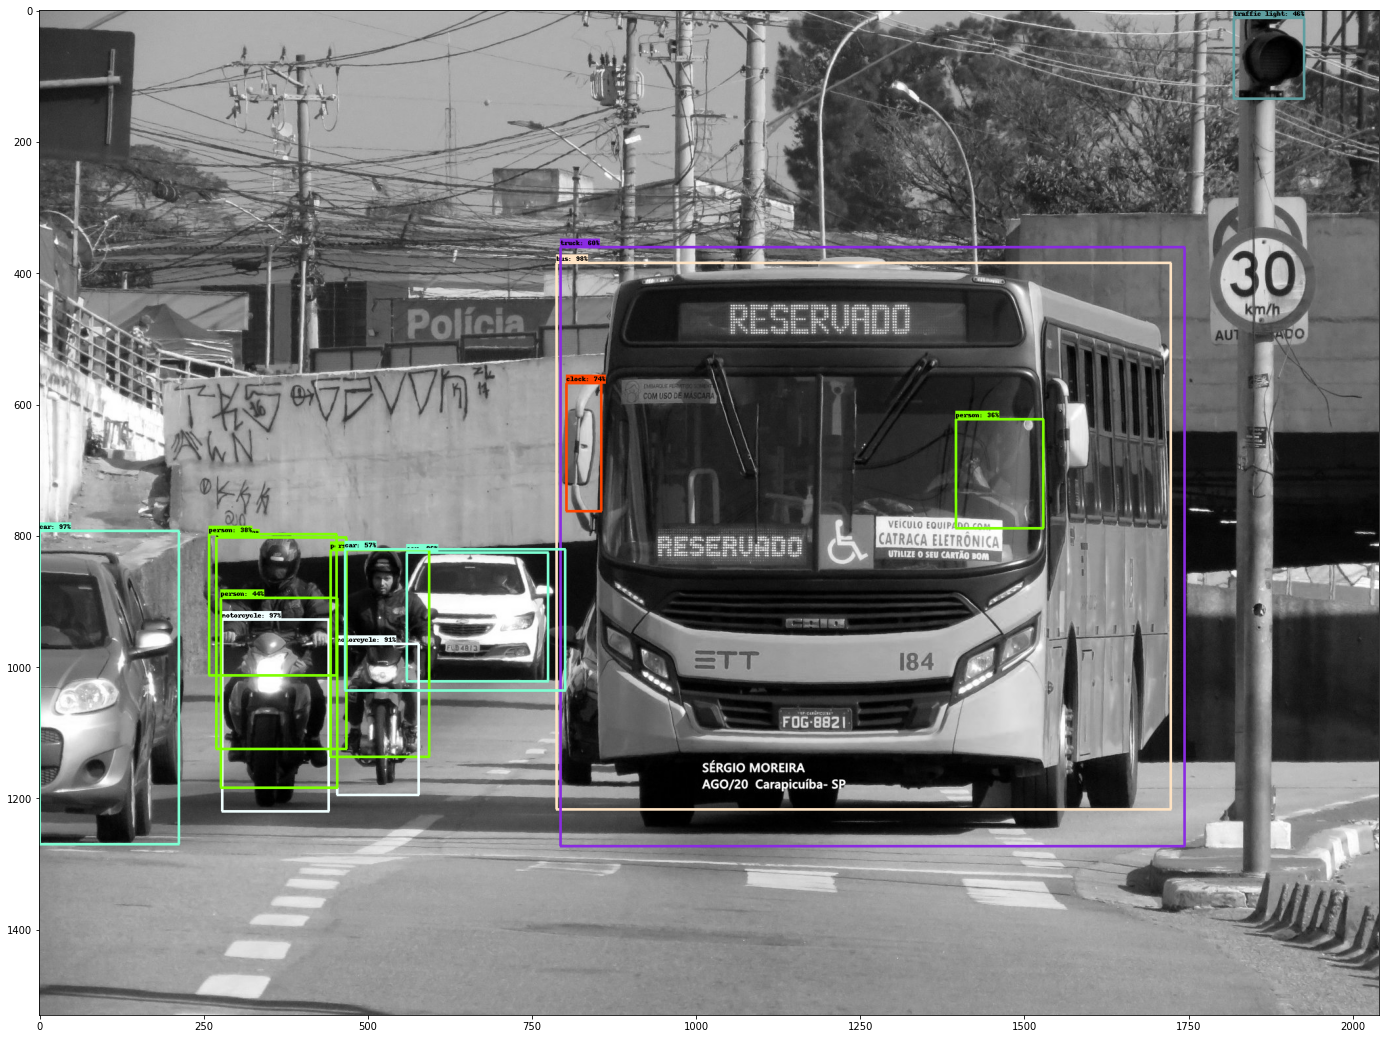

In [450]:
label_id_offset = 0
image_np_with_detections = None
image_np_with_detections = img.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.show()

In [451]:
busDetection = result['detection_classes'] == 6

In [452]:
scoreDetection = result['detection_scores'] > 0.95

In [453]:
box = result['detection_boxes'][np.where(busDetection & scoreDetection)]

In [454]:
box = box.squeeze()

In [455]:
box *= 640

In [456]:
box = box.astype(np.int32)
box

array([161, 247, 509, 540], dtype=int32)

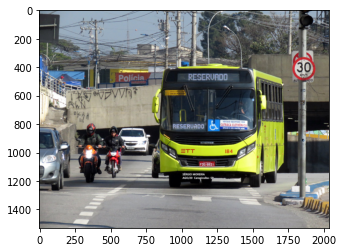

In [457]:
imag = cv2.imread("res.jpg")
orgShape = imag.shape
orgShape
reShape = (640, 640)
xVal = orgShape[0] / reShape[0]
yVal = orgShape[1] / reShape[1]
box[0] *= xVal
box[2] *= xVal
box[1] *= yVal
box[3] *= yVal
# plt.imshow(cv2.cvtColor(imag, cv2.COLOR_BGR2RGB))
imag = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
plt.imshow(imag)

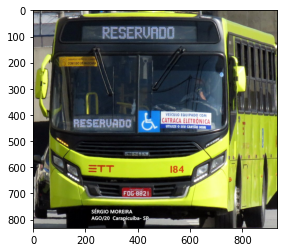

In [458]:
final = imag[box[0] : box[2], box[1] : box[3]]
plt.imshow(final)

In [459]:
gray = cv2.cvtColor(final, cv2.COLOR_BGR2GRAY)
cv2.imwrite("pre.jpg", gray)

True

In [460]:
reader = easyocr.Reader(['pt', 'en'])
res = reader.detect("pre.jpg")

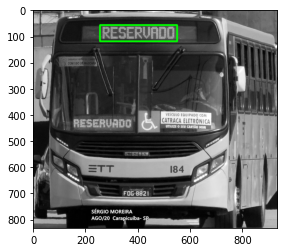

In [461]:
top_left = (res[0][0][0], res[0][0][2])
bottom_right = (res[0][0][1], res[0][0][3])
final = cv2.imread("pre.jpg")
final = cv2.rectangle(final, top_left, bottom_right, (0, 255, 0), 5)
plt.imshow(final)

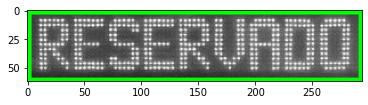

In [462]:
imag = final[top_left[1] : bottom_right[1], top_left[0] : bottom_right[0]]
plt.imshow(cv2.cvtColor(imag, cv2.COLOR_BGR2RGB))

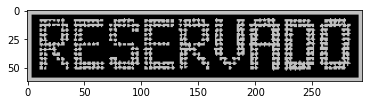

In [463]:
grayImage = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)
th, binImage = cv2.threshold(grayImage, 128, 192, cv2.THRESH_OTSU)
plt.imshow(cv2.cvtColor(binImage, cv2.COLOR_BGR2RGB))

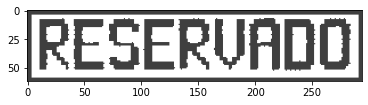

In [464]:
kernel = np.ones((3,3), np.uint8)
img_dilation = cv2.dilate(binImage, kernel, iterations=1)
img_erosion = cv2.erode(img_dilation, kernel, iterations=1)
plt.imshow(255-cv2.cvtColor(img_erosion, cv2.COLOR_BGR2RGB))

In [465]:
reader.readtext(255-cv2.cvtColor(img_erosion, cv2.COLOR_BGR2RGB))

[([[1, 0], [294, 0], [294, 62], [1, 62]], 'GESERVD@]', 0.18572903259252743)]

In [466]:
pytesseract.image_to_string(255-cv2.cvtColor(img_erosion, cv2.COLOR_BGR2RGB))

'RESERVADO\n\x0c'